In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, f1_score
import time
import os


In [2]:
# --- Configuration ---
DATA_FILE = r"C:\Users\jaswa\Downloads\complaints.csv\complaints.csv"
TARGET_CATEGORIES = [
    "Credit reporting, repair, or other",
    "Debt collection",
    "Consumer Loan",
    "Mortgage"
]

print(f"[{time.ctime()}] Starting Data Science Task...")


[Sun Sep 28 22:42:30 2025] Starting Data Science Task...


In [3]:
# --- 1. Data Loading, Filtering, and EDA ---
if not os.path.exists(DATA_FILE):
    print(f"ERROR: Data file '{DATA_FILE}' not found.")
    exit()

df = pd.read_csv(DATA_FILE)
df_filtered = df[df['Product'].isin(TARGET_CATEGORIES)].copy()
df_filtered.dropna(subset=['Consumer complaint narrative'], inplace=True)


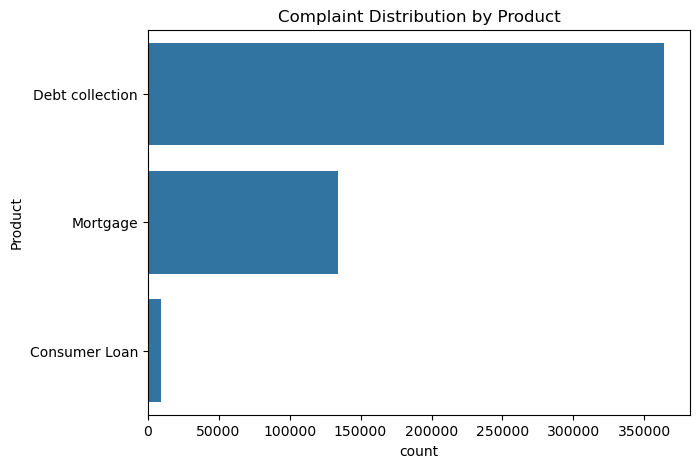


Category Counts:
 Product
Debt collection    364007
Mortgage           133980
Consumer Loan        9461
Name: count, dtype: int64 



In [4]:
# EDA: Distribution of categories
plt.figure(figsize=(7,5))
sns.countplot(y=df_filtered['Product'], order=df_filtered['Product'].value_counts().index)
plt.title("Complaint Distribution by Product")
plt.show()

print("\nCategory Counts:\n", df_filtered['Product'].value_counts(), "\n")

In [5]:

# --- 2. Vectorized Text Pre-Processing ---
stop_words = text.ENGLISH_STOP_WORDS

def preprocess_series(series):
    # Lowercase & remove non-alphabetic
    series = series.str.lower().str.replace(r'[^a-zA-Z]', ' ', regex=True)
    # Remove stopwords (vectorized)
    series = series.apply(lambda x: ' '.join([w for w in x.split() if w not in stop_words]))
    return series

df_filtered['clean_narrative'] = preprocess_series(df_filtered['Consumer complaint narrative'])
print(f"[{time.ctime()}] Text Pre-Processing Complete.")

[Sun Sep 28 22:48:48 2025] Text Pre-Processing Complete.


In [6]:

# --- 3. Feature Engineering ---
category_to_id = {cat: i for i, cat in enumerate(TARGET_CATEGORIES)}
id_to_category = {v: k for k, v in category_to_id.items()}
df_filtered['category_id'] = df_filtered['Product'].map(category_to_id)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, max_features=50000,
                        norm='l2', encoding='latin-1', ngram_range=(1,2))
features = tfidf.fit_transform(df_filtered['clean_narrative'])
labels = df_filtered['category_id']

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.25, random_state=42
)

In [7]:
# --- 4. Model Selection & Training (Multiple Models) ---
models = {
    "Logistic Regression": LogisticRegression(random_state=42, solver='liblinear',
                                              multi_class='ovr', max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC(random_state=42)
}

results = []

for name, model in models.items():
    print(f"[{time.ctime()}] Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    results.append((name, acc, f1))
    print(f"{name} Accuracy: {acc:.4f}, F1 (macro): {f1:.4f}")
    import numpy as np
    unique_labels = np.unique(y_test)  # classes actually present
    present_target_names = [id_to_category[i] for i in unique_labels]
    print(classification_report(y_test, y_pred, labels=unique_labels, target_names=present_target_names))
    print("="*60)

[Sun Sep 28 22:54:12 2025] Training Logistic Regression...


C:\Users\jaswa\anaconda34\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy: 0.9708, F1 (macro): 0.8460
                 precision    recall  f1-score   support

Debt collection       0.98      0.99      0.98     91324
  Consumer Loan       0.83      0.46      0.59      2395
       Mortgage       0.96      0.97      0.96     33143

       accuracy                           0.97    126862
      macro avg       0.92      0.80      0.85    126862
   weighted avg       0.97      0.97      0.97    126862

[Sun Sep 28 22:55:11 2025] Training Naive Bayes...
Naive Bayes Accuracy: 0.9468, F1 (macro): 0.7691
                 precision    recall  f1-score   support

Debt collection       0.98      0.95      0.97     91324
  Consumer Loan       0.69      0.30      0.42      2395
       Mortgage       0.87      0.98      0.92     33143

       accuracy                           0.95    126862
      macro avg       0.85      0.74      0.77    126862
   weighted avg       0.95      0.95      0.94    126862

[Sun Sep 28 22:55:12 2025] Training Lin

In [8]:
# --- 5. Model Comparison Table ---
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 (macro)"])
print("\nModel Performance Comparison:\n")
print(results_df)


Model Performance Comparison:

                 Model  Accuracy  F1 (macro)
0  Logistic Regression  0.970795    0.846023
1          Naive Bayes  0.946785    0.769108
2           Linear SVM  0.972025    0.865044


In [9]:
# --- 6. Prediction Example ---
best_model = models["Linear SVM"]  # usually strongest

def predict_complaint(text_str):
    clean_text = ' '.join([w for w in re.sub(r'[^a-zA-Z]', ' ', text_str.lower()).split() if w not in stop_words])
    features = tfidf.transform([clean_text])
    prediction_id = best_model.predict(features)[0]
    return id_to_category[prediction_id]

sample_complaint = "I received a notice that my house payment was late, despite sending the check on time. This is affecting my credit score unfairly."
print(f"\nPrediction Sample: {sample_complaint[:75]}...")
print(f"Predicted Category: {predict_complaint(sample_complaint)}")


Prediction Sample: I received a notice that my house payment was late, despite sending the che...
Predicted Category: Mortgage
